# Group 4 Notebook file

Members:
- Quang Huy Ha - 44498535
- Khanh Linh Pham - 45483736
- Ehtesam Fayek Utsho - 44469357
- Nguyen Minh Hanh Do - 45524866

# 1. Load and Clean Data

In [1]:
import pandas as pd
import clean
import explore
import numpy as np
from scipy import stats

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# supress some warnings that mess up my slides
import warnings; warnings.simplefilter('ignore')

In [2]:
# load freedom data
freedom = pd.read_csv('../data/clean-data/human-freedom-15-17.csv')
freedom = freedom.dropna()
freedom.shape

(480, 17)

In [3]:
# load 2015-2017 data
happy = pd.read_csv('../data/clean-data/clean-happiness-15-17_using python.csv')

In [4]:
# load emission data
emission = pd.read_csv('../data/clean-data/co-emissions-per-capita15-18.csv')

In [5]:
# merge freedom and happy and emission
df = pd.DataFrame()
df = pd.merge(happy,freedom,  how='inner', left_on=['Year','Country'], right_on=['Year','Country'])
df = pd.merge(df,emission,  how='inner', left_on=['Year','Country'], right_on=['Year','Country'])
df = df.dropna()
df.shape

(393, 28)

In [6]:
# data frame may have countries that has less than 3 records, we have to remove that.
clean.delete_less_than_record(df,3)
# new shape after removing
df.shape

['Belarus', 'Iraq', 'Sudan']


(387, 28)

In [7]:
# checking to ensure there is no null value in the dataframe
df.isna().sum().sum()

0

In [8]:
# drop freedom because dataset human freedom already has freedom score 'hf_score'. freedom in happiness is no longer neccessary
df = df.drop(['Freedom','dystopia_residual'],axis=1)
df.rename(columns={'Per capita CO2 emissions':'CO2_per_cap'},inplace=True)
df.shape

(387, 26)

In [9]:
df.columns

Index(['Country', 'Region', 'happiness_score', 'GDP_per_cap', 'Family',
       'life_expect', 'gov_trust', 'Generosity', 'continent', 'Year',
       'hf_score', 'hf_quartile', 'pf_rol', 'pf_ss', 'pf_movement',
       'pf_religion', 'pf_expression', 'pf_identity', 'pf_score',
       'ef_government', 'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation',
       'ef_score', 'CO2_per_cap'],
      dtype='object')

# 2. Data exploration

## 2.1 Variable explanation
- **GDP_per_cap** : Gross Domestic Product of a country, implying money factor
- **Family**: Family Support (either financially or psychologically) of people in the country
- **Life_expect**: Life expectancy score where 0 is the minimum and 1 is the top most, implying health factor
- **gov_trust**: Government trust score where 0 is the minimum and 1 is the top most, implying the level of trustworthy that a government is to its citizens
- **Generosity**: Generosity score where 0 is the minimum and 1 is the top most, implying the generosity level of people living in the same country
- **pf_rol**: Rule of Law, how the country maintain the rules and laws, implying factor relating to civilization and criminalism in a country
- **pf_ss**: Security and safety of citizens
- **pf_movement**: Freedom of movement of the people
- **pf_religion**: Religious freedom of the people
- **pf_association**:Association, Assembly, and Civil Society - How associate score for the country
- **pf_expression**: Freedom of expression and information
- **pf_identity**: Freedom of identity and relationship (e.g. LGBTQ+)
- **ef_government**: Government size of the country
- **ef_legal**: How legal system and property rights are maintained, implying factor relating to legal restrictions, gender legislation being authorized or not, strong/weak military state, integrity of courts and legal system in a country
- **ef_money**: Cash flow in legal ways
- **ef_trade**:Freedom to Trade Internationally - Trade internationally freely without any restrictions
- **ef_regulation**:Regulation of Credit, Labor, and Business - How regulation are well maintained
- **ef_rank**: Economic freedom of the country in general
- **hf_score**: Freedom score of the people in the country in general
- **CO2_per_cap**:Per Capita CO2 emissions - Carbondioxide emission rate per capita. 

## 2.2 Distribution of hapiness score

Text(0.5, 1.0, 'Happiness Score Distribution')

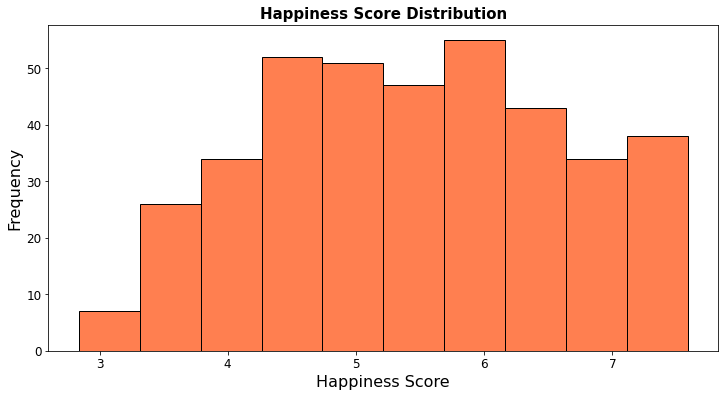

In [10]:
#Plotting histogram to see Happiness Score distribution

#set size for the histogram
plt.figure(figsize=(12, 6))
ax = plt.gca()

#plot the histogram
plt.hist(df['happiness_score'], edgecolor = 'black', linewidth = 1, color = "coral")

#adjust x label, y label
plt.xlabel("Happiness Score", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

#adjust sizes of x, y ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#set title for the histogram
plt.title('Happiness Score Distribution', fontweight='bold', fontsize=15)

**COMMENTS**: From the above graph above, the distribution of happiness score is mostly **normally distributed**. Most of the happiness score values range from 4.5 to 6.5, with the highest frequency belonging to happiness score of 6. This can be inferred that all over the world from 2015-2017, there are roughly 55 countries with people living with the highest happiness and satisfaction and are assigned the happiness score of 6. Approximately 8 countries experience the lowest happiness score of 3, indicating that people in those 8 countries are experiencing the ultimate unsatisfaction compared to other countries around the world. 

## 2.3 Variable Correlation (using Pairplot & Heatmap)
 **Showing relationship between each variables:**
 - The first pairplot shows the relationship between happiness score and general social factors.
 - The second pairplot shows the relationship between happiness score and freedom factors.
 - 2 heatmaps reassures assumptions on relationships explored. 
 
 **Note:**
 - ef_score and pf_score are the 2 determinants of hf_score (human freedom)
 - ef_score and pf_score are also determined by a variety of other scores such as 'pf_rol', 'pf_ss', 'ef_money', 'ef_trade', etc. 
 - We will use those small scores (pf_rol, pf_ss, ef_money, .....) instead of ef_score, pf_score, hf_score in the second pairplot

### 2.2.1 Pairplot showing relationship between Happiness with all other factors

#### Relationship between Happiness Score and other social factors

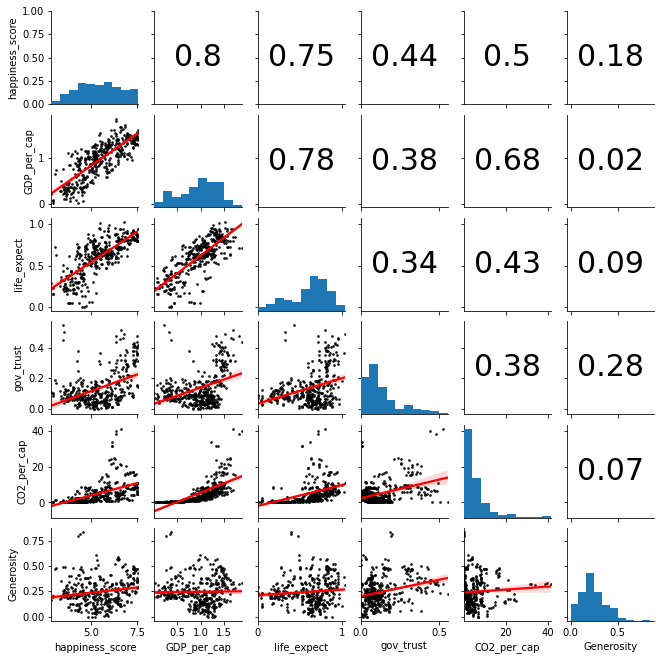

In [11]:
def disp_pearson(x,y, **kws):
    corrmat = np.corrcoef(x,y)
    pearson = round(corrmat[0,1], 2)
    ax = plt.gca()
    ax.annotate(pearson, [.5, .5], xycoords = "axes fraction", ha = "center", va = "center", fontsize = 30)

pairplot_no_freedom = df[['happiness_score','GDP_per_cap', 'life_expect', 'gov_trust', 'CO2_per_cap','Generosity']]

s = sns.PairGrid(pairplot_no_freedom, height = 1.5)
s = s.map_diag(plt.hist)
s = s.map_lower(sns.regplot, color = 'black', scatter_kws = {"s":3}, line_kws = {'color' : 'r'})
s = s.map_upper(disp_pearson)

**COMMENTS**: Here, we are showing relation between happiness_score and other factors which include GDP per capita, life expectancy, government trust, carbon-di-oxide emission per capita and generosity of a country. Here, number 1 represent the strongest relation where as 0 being the weakest. It is clear from the pair plot that happiness score has the strongest relation with GDP and the weakest relation with Generosity. Further relationship exploration will be discussed in the heatmap below.

#### Relationship between Happiness Score and Factors relating to Freedom

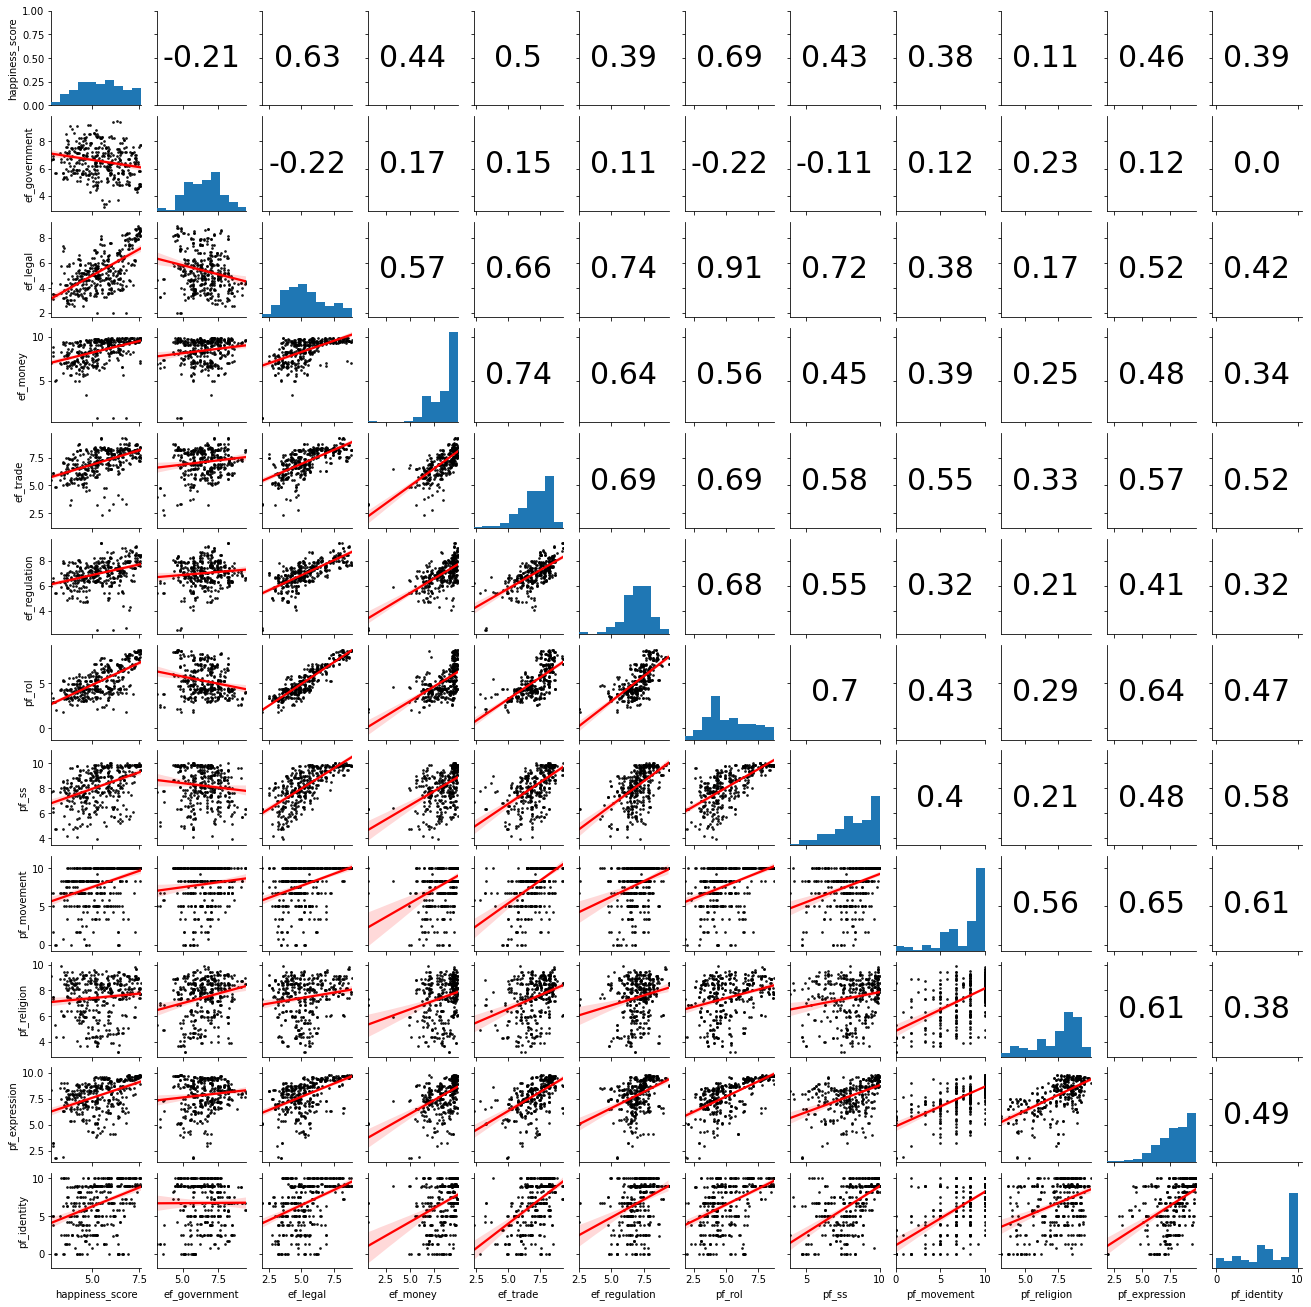

In [12]:
pairplot_freedom = df[['happiness_score','ef_government', 'ef_legal', 'ef_money', 'ef_trade','ef_regulation','pf_rol', 'pf_ss','pf_movement', 'pf_religion', 'pf_expression', 'pf_identity']]
s = sns.PairGrid(pairplot_freedom, height = 1.5)
s = s.map_diag(plt.hist)
s = s.map_lower(sns.regplot, color = 'black', scatter_kws = {"s":3}, line_kws = {'color' : 'r'})
s = s.map_upper(disp_pearson)

**COMMENTS**: Here, we are showing relation between happiness_score and all other factors. Here, 1 represent the strongest relation whereas -1 being the weakest. It is clear from the pair plot that happiness score has the strongest relation with Rule of law (pf_rol) and the weakest relation with Size of Government (ef_government). Further relationship exploration will be discussed in the heatmap below.

### 2.2.2 Heatmap showing relationship between Happiness with all other factors

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text major ticklabel objects>)

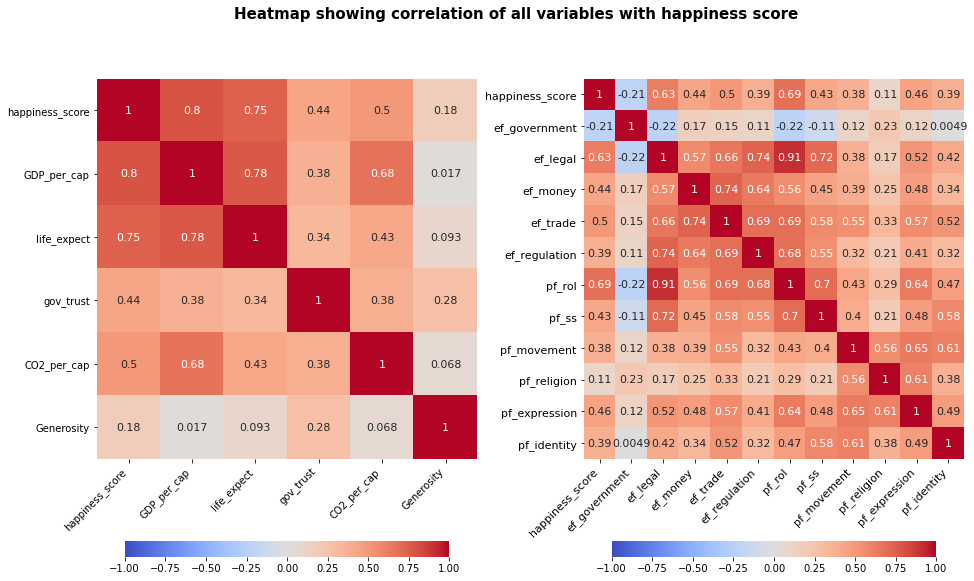

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,10))
fig.suptitle('Horizontally stacked subplots')

corr_no_freedom_data = df.filter(['happiness_score','GDP_per_cap', 'life_expect', 'gov_trust', 'CO2_per_cap','Generosity'], axis=1)
corr_no_freedom = corr_no_freedom_data.corr()
corr_freedom_data = df.filter(['happiness_score','ef_government', 'ef_legal', 'ef_money', 'ef_trade','ef_regulation','pf_rol', 'pf_ss','pf_movement', 'pf_religion', 'pf_expression', 'pf_identity'], axis=1)
corr_freedom = corr_freedom_data.corr()

no_freedom = sns.heatmap(corr_no_freedom, annot = True,ax=ax1,vmin = -1, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.8,"orientation":"horizontal"}, cmap = 'coolwarm', annot_kws={"fontsize":11})
no_freedom.set_xticklabels(no_freedom.get_xticklabels(), rotation=45, horizontalalignment='right')

freedom = sns.heatmap(corr_freedom, annot = True,ax=ax2,vmin = -1, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.8,"orientation":"horizontal"}, cmap = 'coolwarm', annot_kws={"fontsize":11})
freedom.set_xticklabels(freedom.get_xticklabels(), rotation=45, horizontalalignment='right')

fig.suptitle('Heatmap showing correlation of all variables with happiness score', fontweight='bold', fontsize=15)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

**Heatmap Interpretation Note**: 
- Positive linear relationship: the darker the red (where correlation is closer to 1), the stronger the positive relationship. 
- Negative linear relationship: the darker the blue (where correlation is closer to 1), the stronger the negative relationship. 
- Neutral relationship: the color is white/almost white (where the correlation is relatively 0). This means 2 variables are not related, or barely related to each other. 
- The heatmap on the left shows relationships between Happiness Score and other general social factors
- The heatmap on the right shows relationships between Happiness Score and factors relating to freedom

**COMMENTS**: 
- **Happiness Score vs GDP per cap:** there's a strong positive relationship between 2 variables (coefficient = 0.8, which is near to 1). It means as GDP per cap increases, happiness score increases as well.
- **Happiness Score vs Life expect:** there's a strong positive relationship between 2 variables (coefficient = 0.75, which is near to 1). It means as life expectancy increases, happiness score also increases. Thus, people with better health are likely to be happier
- **Happiness Score vs Family:** there's a positive relationship between 2 variables (coefficient = 0.64). This suggests as people have better family background/relationship, they are more likely to be happy
- **GDP per Cap vs Per capita CO2 emissions:** There's a strong relationship between variables, meaning as emissions increase, GDP also increases
- **Happiness Score vs Freedom indices (heatmap on the right):** There are medium positive relation between happiness score and some freedom variables such as pf_rol (0.69), ef_legal (0.63) and ef_trade (0.5). This indicates as metrics measuring qualities of Rules of Laws, legal systems and trading legislation in a country increases, happiness score in that country will increase as well. The rest of freedom variables are below 0.5 with the worst relationship is pf_religion with happiness score (0.11), which is close to 0 - no correlation. 

# 3. Clustering 

## 3.1 Draw a dendrogram to identify the optimal number of clusters

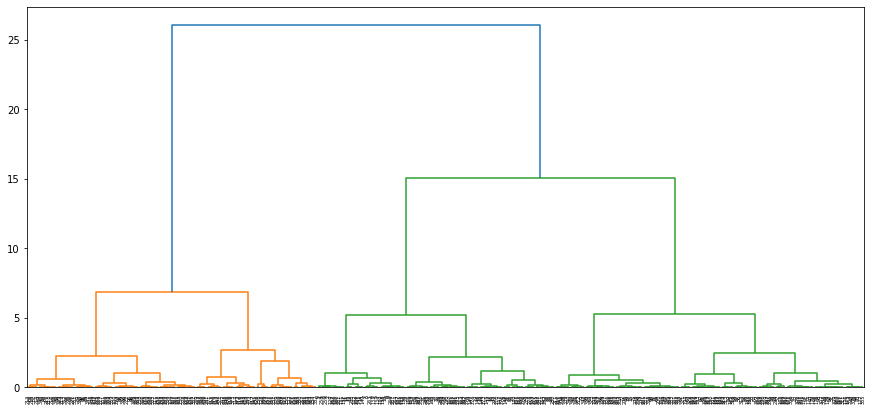

In [14]:
# work on a copy of just a couple of variables
df_dendrogram = df[['happiness_score']].copy()

# compute the distance matrix
dist = pdist(df_dendrogram, 'euclidean')
linkage_matrix = linkage(dist,method = 'ward')  # or 'average'

plt.figure(figsize=(15,7))
dendrogram(linkage_matrix)
plt.show()

**Comment:** Based on the dendrogram using only 'happiness_score' with euclidean distance, dataframe is clustered into 3 groups (as it is divided into orange and green color sections, and combined by blue color line). Therefore, we can apply the number of clusters = 3 for Kmeans Clustering below. 

**Note:** Despite unclear labels on the x-axis, the purpose of the dendrogram is to find the number of clusters so labels are not necessarily significant here. 

## 3.2 Apply Kmeans clustering with k = 3

**Note:** Since the question revolves around "Is money the only determinant of human happiness?", we would only choose the 'happiness_score' and 'GDP_per_cap' for our k_means cluter. Moreover, since 3 clusters were determined for dendrogram, we would choose number of clusters equal to 3.

In [15]:
#create a new dataframe with just 2 most important variables
df_kmeans = df[['happiness_score', 'GDP_per_cap']]

#fit the KMeans model
km = KMeans(n_clusters = 3)
km.fit(df_kmeans)

df_kmeans['label'] = km.predict(df_kmeans)

#see unique values in 'label'
set(df_kmeans['label'])

{0, 1, 2}

In [16]:
# find the mean value for each column by cluster
df_kmeans_mean = df_kmeans.groupby(['label']).mean()
df_kmeans_mean

,happiness_score,GDP_per_cap
label,,
0,5.443185,1.023459
1,4.083378,0.516079
2,6.852128,1.349670


**COMMENT**: Clusters are now labeled based on the descending order of happiness score 
- Label 0: medium happiness score (approximately 5.44)
- Label 1: lowest happiness score (approximately 4.08)
- Label 2: highest happiness score (approximately 6.85)

#### Graph showing the clustering of happiness score based on GDP_per_cap

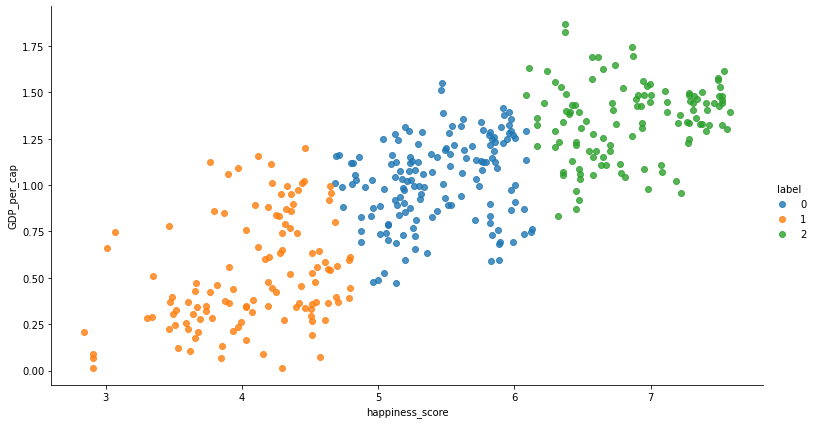

In [17]:
p = sns.lmplot("happiness_score", "GDP_per_cap", data=df_kmeans, fit_reg=False, hue='label',size=6,aspect=1.8)

**COMMENT**: The 3 clusters are distinct from each other. We can now conclude that happiness score of is divided into:
- Low Happiness Score: label 1(approximately 3 - 4.5)
- Medium Happiness Score: label 0 (approximately 4.5 - 6)
- High Happiness Score: label 2(approximately 6 - 7.5)

#### Merge the data again with categorical data so that we know which country belongs to which category

In [18]:
df_lable = pd.merge(df, df_kmeans,  how='inner', left_on=['happiness_score', 'GDP_per_cap'], right_on=['happiness_score', 'GDP_per_cap'])
df_lable.head()

,Country,Region,happiness_score,GDP_per_cap,Family,life_expect,gov_trust,Generosity,continent,Year,...,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,CO2_per_cap,label
0,Switzerland,Western Europe,7.587,1.39651,1.34951,0.94143,0.41978,0.29678,Europe,2015,...,9.0,9.20,7.7,8.6,9.8,7.5,8.5,8.42,4.667728,2
1,Iceland,Western Europe,7.561,1.30232,1.40223,0.94784,0.14145,0.43630,Europe,2015,...,9.0,9.13,5.8,8.5,7.2,7.2,8.0,7.31,10.707197,2
2,Denmark,Western Europe,7.527,1.32548,1.36058,0.87464,0.48357,0.34139,Europe,2015,...,10.0,9.34,4.7,8.2,9.6,8.4,8.4,7.86,6.188109,2
3,Norway,Western Europe,7.522,1.45900,1.33095,0.88521,0.36503,0.34699,Europe,2015,...,10.0,9.39,4.9,8.8,7.0,7.7,7.8,7.24,8.712221,2
4,Canada,North America,7.427,1.32629,1.32261,0.90563,0.32957,0.45811,America,2015,...,9.0,9.11,6.3,7.9,9.6,7.9,8.5,8.03,16.009017,2


#### Top Happiness Score Group

In [19]:
# top group
df_top = df_lable[df_lable['label']==2]
df_top = df_top.sort_values(by='happiness_score',ascending=False,ignore_index=True)
df_top.head(6)

,Country,Region,happiness_score,GDP_per_cap,Family,life_expect,gov_trust,Generosity,continent,Year,...,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,CO2_per_cap,label
0,Switzerland,Western Europe,7.587,1.396510,1.349510,0.941430,0.419780,0.296780,Europe,2015,...,9.0,9.20,7.7,8.6,9.8,7.5,8.5,8.42,4.667728,2
1,Iceland,Western Europe,7.561,1.302320,1.402230,0.947840,0.141450,0.436300,Europe,2015,...,9.0,9.13,5.8,8.5,7.2,7.2,8.0,7.31,10.707197,2
2,Norway,Western Europe,7.537,1.616463,1.533524,0.796667,0.315964,0.362012,Europe,2017,...,9.2,9.26,4.9,8.5,9.6,7.6,7.6,7.62,8.251931,2
3,Denmark,Western Europe,7.527,1.325480,1.360580,0.874640,0.483570,0.341390,Europe,2015,...,10.0,9.34,4.7,8.2,9.6,8.4,8.4,7.86,6.188109,2
4,Denmark,Western Europe,7.526,1.441780,1.163740,0.795040,0.444530,0.361710,Europe,2016,...,10.0,9.16,4.7,8.1,9.9,8.5,8.3,7.88,6.482129,2
5,Norway,Western Europe,7.522,1.459000,1.330950,0.885210,0.365030,0.346990,Europe,2015,...,10.0,9.39,4.9,8.8,7.0,7.7,7.8,7.24,8.712221,2


**Comments:** From the table, it is shown that 4 happiest countries that belong to group label 2 in the world are: Switzerland, Iceland, Norway, Denmark. This indicates that people living Western Europe countries who receive high well-being benefits and life quality are the happiest among the world. Notably, Norway and Denmark have their scores on top ranking for 2 consecutive years, asserting that life quality in those countries are exceptionally good. 

In [20]:
#bottom group
df_bottom = df_lable[df_lable['label']==1]
df_bottom = df_bottom.sort_values(by='happiness_score',ascending=True,ignore_index=True)
df_bottom.head()

,Country,Region,happiness_score,GDP_per_cap,Family,life_expect,gov_trust,Generosity,continent,Year,...,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,CO2_per_cap,label
0,Togo,Sub-Saharan Africa,2.839,0.208680,0.139950,0.284430,0.107310,0.166810,Africa,2015,...,5.0,6.62,6.6,4.4,7.0,5.5,6.0,5.88,0.368851,1
1,Burundi,Sub-Saharan Africa,2.905,0.091623,0.629794,0.151611,0.084148,0.204435,Africa,2017,...,3.8,4.95,6.9,3.5,8.2,5.9,6.3,6.17,0.046947,1
2,Burundi,Sub-Saharan Africa,2.905,0.068310,0.234420,0.157470,0.094190,0.202900,Africa,2016,...,5.0,4.52,6.7,3.5,8.8,6.1,6.3,6.27,0.046075,1
3,Burundi,Sub-Saharan Africa,2.905,0.015300,0.415870,0.223960,0.100620,0.197270,Africa,2015,...,5.0,4.19,6.7,3.1,7.8,6.1,6.6,6.06,0.038556,1
4,Syria,Middle East and Northern Africa,3.006,0.663200,0.474890,0.721930,0.189060,0.471790,Africa,2015,...,0.0,2.79,5.7,3.4,4.9,4.9,5.4,4.87,1.593346,1


**Comments:** From the table, it is shown that 3 least happy countries that belong to group label 1 in the world are: Togo, Burundi, Syria. This indicates that people living in Africa countries who are likely to receive poor living conditions are the the least happy in the world. Notably, Burundi has their scores at the bottom of the ranking for 3 consecutive years, asserting that life quality in this country is exceptionally bad and people struggle a lot to obtain happiness.

In [21]:
# middle group
df_middle = df_lable[df_lable['label']==0]
df_middle = df_middle.sort_values(by='happiness_score',ascending=True,ignore_index=True)
for i in range(0,5):
    row = df_middle.iloc[int(len(df_middle.index)/2) - 2 + i]
    print(row['Country'],"- happiness score:",row['happiness_score'] )

Turkey - happiness score: 5.3889999999999985
Serbia - happiness score: 5.39499998092651
Indonesia - happiness score: 5.399
Estonia - happiness score: 5.4289999999999985
Philippines - happiness score: 5.42999982833862


**Comments:** From the table, it is shown that 5 countries with medium happiness that belong to group label 0 in the world are: Turkey, Serbia, Indonesia, Estonia, Philippines. These countries are all developing countries, with average living conditions. This infers that developing countries still confront with struggles to develop while it is not too hard for them to make ends meat, so they feel a medium level of happiness.  

# 4. Regression Models

In [19]:
# create a list to hold results from all models to compare later
r2_gdp = []
r2_optimised = []
rmse_gdp = []
rmse_optimised = []

## 4.1 Split data into train and test 
- X, y, X_train, y_train, X_test, y_test are the data set for all columns
- X_gdp, y_gdp, X_gdp_train, y_gdp_train, X_gdp_test, y_gdp_test are the data set for gdp and happiness columns

**Note**: For each model, first, only GDP_per_cap will be used to predict Happiness Score. Then, multiple variables will be used to predict happiness score to observe if there is an improvement in the model.

Under each heading section as **"Use multiple variables to predict Happiness Score + Model Name"**, those variables listed as below will be used:

1. GDP_per_cap
2. life_expect
3. pf_rol
4. gov_trust
5. ef_legal 
6. Generosity
7. Family
8. pf_religion
9. pf_expression
10. CO2_per_cap
11. pf_ss
12. ef_regulation
13. ef_money
14. ef_government
15. ef_trade
16. pf_identity
17. pf_movement

### Use multiple variables to predict Happiness Score

In [20]:
X = df.drop(['happiness_score', 'Country', 'Region', 'continent', 'Year', 'ef_score', 'pf_score', 'hf_quartile', 'hf_score'], axis = 1)
y = df['happiness_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (309, 17)
y_train shape:  (309,)
X_test shape:  (78, 17)
y_test shape:  (78,)


### Use only GDP_per_cap to predict the happiness score

In [21]:
X_gdp = df[['GDP_per_cap']]
y_gdp = df['happiness_score']
#X_gdp_train, X_gdp_test, y_gdp_train, y_gdp_test = train_test_split(X_gdp, y_gdp, test_size=0.2)
X_gdp_train = X_train[['GDP_per_cap']]
X_gdp_test = X_test[['GDP_per_cap']]
y_gdp_train = y_train
y_gdp_test = y_test
print("X_train gdp shape: ",X_gdp_train.shape)
print("y_train gdp shape: ",y_train.shape)
print("X_test gdp shape: ",X_gdp_test.shape)
print("y_test gdp shape: ",y_gdp_test.shape)

X_train gdp shape:  (309, 1)
y_train gdp shape:  (309,)
X_test gdp shape:  (78, 1)
y_test gdp shape:  (78,)


## 4.2 Linear regression (Model 1)

In [22]:
# Create list of scores to compare each test of linear regression model
train_rmse_list = []
train_r2_list = []
train_mae_list = []
train_mape_list = []

test_rmse_list = []
test_r2_list = []
test_mae_list = []
test_mape_list = []

### 4.2.1 Use only GDP_per_cap to predict Happiness Score (Linear)

In [23]:
# instantiating the model
lr = LinearRegression()

# model training
lr.fit(X_gdp_train, y_gdp_train)

#predicting on training and testing test
y_train_pred = lr.predict(X_gdp_train)
y_test_pred = lr.predict(X_gdp_test)

# store the results for comparison
explore.store_scores_all_models(rmse_gdp,r2_gdp,y_gdp_test, y_test_pred)
explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_gdp_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_gdp_test, y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_gdp_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_gdp_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.6815104883503361
R2-score:  0.6512033887032904
MAE:  0.5469921963830786
MAPE:  10.44821501634617

--------Metric scores on testing set--------
RMSE:  0.7860646394039879
R2-score:  0.5648326579897576
MAE:  0.6687717726034956
MAPE:  12.918463149591966



**Comment:** As seen from the model result, the results from train set and test set are pretty close to. If we have a closer look at each variable of both test and train model, the results of each score don't differ much from the others. This indicates the model is **NOT overfitting**. However, with the moderately high error score of RMSE (0.68) and MAE (0.54) while the R2_score is at medium level, we could confirm that the model is **underfitting**. Therefore, the Linear Regression model does not do a good job training the model using money factor. 

In [24]:
print("The equation of using GDP is:")
print("y = ", lr.coef_, "* x + ", lr.intercept_) 

The equation of using GDP is:
y =  [2.23407254] * x +  3.2860595714790026


### 4.2.2 Use all variables to predict Happiness Score (Linear)

In [25]:
# instantiating the model
lr = LinearRegression()

# model training
lr.fit(X_train, y_train)

#predicting on training and testing test
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# store the results for somparison
explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.4979560783523355
R2-score:  0.8137873223819054
MAE:  0.39748187358333514
MAPE:  7.769398268491004

--------Metric scores on testing set--------
RMSE:  0.6575115297239538
R2-score:  0.6955285886230468
MAE:  0.523694899885597
MAPE:  11.153281979666705



**Comment:** As seen from the model result, when we use all variables that we have, the model has some improvement with lower error (RMSE: 0.68 down to 0.50, MAP: 0.55 down to 0.40) while the R2-score is higher (from 0.65 to 0.81). This improvement make the model **less underfitting** or could be considered **no longer underfitting**. Moreover, if we have a look at The test model, we could also see the improvement of all scores. The test model performed slightly worse than the train model but we could not confirm that it's overfitting or not. In general, the linear regression model perform better when using all provided variables and the performance is pretty good.

In [26]:
print("The equation of everything is:")
print("y = ", lr.coef_, "* x + ", lr.intercept_) 

The equation of everything is:
y =  [ 0.98599419  0.60126202  1.40228376  2.27112551  0.93936588  0.07375098
 -0.12573568  0.03912954 -0.07573691  0.08858309  0.04697008  0.00431035
  0.00560414  0.09717038 -0.08438991 -0.2283872   0.00264849] * x +  3.72394405641482


### 4.2.3 Apply RFE and Cross-validation to find the most optimal features (Linear)
RFE will try all combination from 1 feature to 18 features to see how many features in a combination will get the best result.

In [27]:
estimator = LinearRegression()

rmse_scores = []
r2_scores = []

for i in range(1, len(X_train.columns)+1):
    selector = RFE(estimator, n_features_to_select=i, step=1)
    score_rmse = cross_val_score(selector, X, y, scoring='neg_root_mean_squared_error', cv=5)
    score_r2 = cross_val_score(selector, X, y, scoring='r2', cv=5)
    
    print('%d features, have (r2, rmse) as: (%f, %f)' %(i,score_r2.mean(),-score_rmse.mean()))
    
    r2_scores.append(score_r2.mean())
    rmse_scores.append(-score_rmse.mean())

1 features, have (r2, rmse) as: (0.135109, 0.827347)
2 features, have (r2, rmse) as: (0.211973, 0.791929)
3 features, have (r2, rmse) as: (0.191469, 0.756538)
4 features, have (r2, rmse) as: (0.310586, 0.701208)
5 features, have (r2, rmse) as: (0.373484, 0.653449)
6 features, have (r2, rmse) as: (0.388403, 0.643736)
7 features, have (r2, rmse) as: (0.415857, 0.620629)
8 features, have (r2, rmse) as: (0.418321, 0.623686)
9 features, have (r2, rmse) as: (0.423357, 0.621284)
10 features, have (r2, rmse) as: (0.408437, 0.628547)
11 features, have (r2, rmse) as: (0.413367, 0.625510)
12 features, have (r2, rmse) as: (0.417507, 0.623427)
13 features, have (r2, rmse) as: (0.440588, 0.613292)
14 features, have (r2, rmse) as: (0.449018, 0.608983)
15 features, have (r2, rmse) as: (0.463028, 0.601965)
16 features, have (r2, rmse) as: (0.463460, 0.601767)
17 features, have (r2, rmse) as: (0.458730, 0.604247)


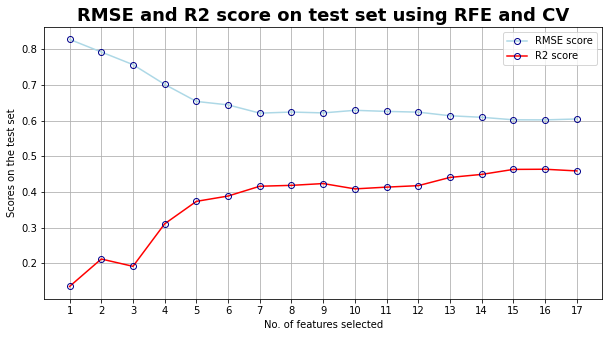

<Figure size 864x432 with 0 Axes>

In [28]:
# Plot the RMSE and R2 scores of 1-17 features
explore.plot_compare_features(r2_scores,"R2 score", rmse_scores,"RMSE score",len(X_train.columns))

In [29]:
best_r2, best_rmse = explore.find_best_combination_index(r2_scores, rmse_scores)
print("RMSE, R2 and MAE has best result using number of feature respectedly:",best_r2, best_rmse)

RMSE, R2 and MAE has best result using number of feature respectedly: 16 16


**COMMENT:** From the RFE function and the plot above, we could conclude that the combination of 16 features will give the highest R2 scores and lowest RMSE score. Using cross validation, the means of results are reported as below:
- r2 score on test set using 16 features: 0.463460
- root_mean_squared_error on test set using 16 features: 0.601767

The function below will find all 16 best features with ranking #1 while the non-selected one will be rank from #2.

In [30]:
#find the ranking
print(explore.features_ranking(LinearRegression(),16,X, y))

          Feature  Ranking
0     GDP_per_cap        1
14       ef_trade        1
13       ef_money        1
12       ef_legal        1
11  ef_government        1
10    pf_identity        1
9   pf_expression        1
15  ef_regulation        1
8     pf_religion        1
6           pf_ss        1
5          pf_rol        1
4      Generosity        1
3       gov_trust        1
2     life_expect        1
1          Family        1
7     pf_movement        1
16    CO2_per_cap        2


From the chart above, the best 16 features are those all features excluding CO2_per_cap

### 4.2.4 Use 16 most optimal features to predict Happiness Score (Linear)

In [31]:
# using new selected 16 features to see how the model improve
X_best_train = X_train.drop(['CO2_per_cap'],axis=1)
X_best_test = X_test.drop(['CO2_per_cap'],axis=1)

lr = LinearRegression()

# model training
lr.fit(X_best_train, y_train)

#predicting on training and testing test
y_train_pred = lr.predict(X_best_train)
y_test_pred = lr.predict(X_best_test)

# store the results for comparison
explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.49808227769600016
R2-score:  0.8136929249176859
MAE:  0.39739957339452736
MAPE:  7.769419754576251

--------Metric scores on testing set--------
RMSE:  0.6572182636855409
R2-score:  0.6958001312731408
MAE:  0.5242308509645385
MAPE:  11.165616084544194



**COMMENT**: After finding 16 best features (all variables exclude CO2_per_cap), we test the model again using those 16, the result does't seem to change significantly. The scores only change at the second or third decimal places for both train and test models. The gap between train and test model remain the same. To sum up, the implementation of train, test for 16 best features give a similar results to using all 17 features. The linear regression model performs as good as using all 17 features.

### 4.2.5 Using Polynomial  Regression to improve Linear Regression
The linear regression uses line model and try to fit variables into the line model then predict using that model. We could improve this by applying polynomial features. The idea is that with every entry from X set, the polynomial feature will transfor it into multiple points to create a curve which would fit all entries better. However, this means if there exist outlier, the polynomial model will be affected significantly

**Improving 16 selected important features using Polynomial regression**

These variables are choosen by linear regression. In fact, in order to get these feature, we only need to drop CO2_per_cap
- GDP_per_cap
- ef_trade
- ef_money
- ef_legal
- ef_government
- pf_identity 
- pf_expression
- ef_regulation  
- pf_religion 
- pf_ss   
- pf_rol  
- Generosity
- gov_trust  
- life_expect  
- Family 
- pf_movement 

In [32]:
# using new selected 16 features to see how the model improve
X_best_train = X_train.drop(['CO2_per_cap'],axis=1)
X_best_test = X_test.drop(['CO2_per_cap'],axis=1)

poly = PolynomialFeatures() 
# transfor X into X_poly
X_poly = poly.fit_transform(X_best_train) 

# using regression
lr = LinearRegression() 
lr.fit(X_poly,y_train)

#predicting on training and testing test
y_train_pred_poly = lr.predict(poly.fit_transform(X_best_train))
y_test_pred_poly = lr.predict(poly.fit_transform(X_best_test))

# store the results for comparison
explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred_poly)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred_poly)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred_poly)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred_poly)

--------Metric scores on training set--------
RMSE:  0.2309681259655371
R2-score:  0.9599381251265332
MAE:  0.1792069715666542
MAPE:  3.443862371002072

--------Metric scores on testing set--------
RMSE:  0.9457913467266399
R2-score:  0.3700146542132431
MAE:  0.5505288280340341
MAPE:  12.209950808712442



**COMMENTS**: The use of polynomial features seems to prove the test on the train model by a lot with the error reduce sifnificantly (RMSE 0.5 down to 0.23 and MAE 0.4 down to 0.18) while the R2 score reach 0.96 (improved from 0.81). However, the test on test set is worsen off with very high error scores (RMSE is 0.95 and MAE is 0.55) while the R2 score is significantly low (0.37). Linear regression using Polynomial feature is **overfitting** and produce worse result than the original model. The reason of this could be :
- The degree is not set at correct number: We are currently using the default value provided by polynomial feature function (degree = 2)
- There exist outliers: There could be outliers in the data set and polynomial regression is very sensitive with outliers. 1 or 2 outliers can totally set the model prediction off the track

### 4.2.6 Comparing all train-test of linear regression

#### Test using train model

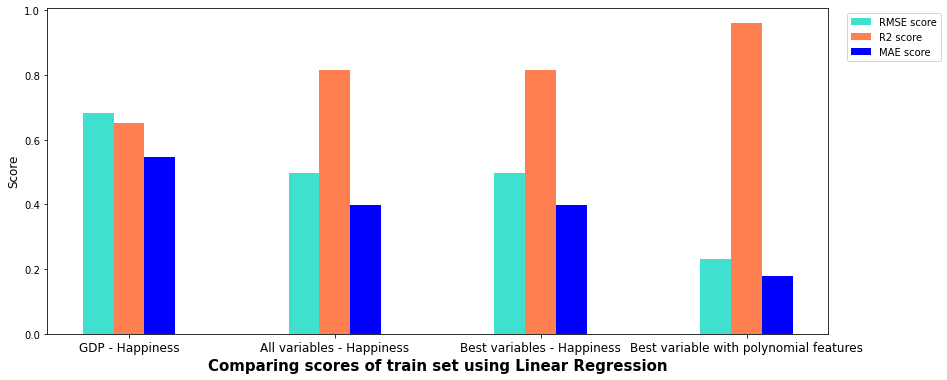

In [33]:
names = ['GDP - Happiness', 'All variables - Happiness', 'Best variables - Happiness','Best variable with polynomial features']
explore.plot_compare_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list,"Comparing scores of train set using Linear Regression",names)

**COMMENTS**: The 16 features (excluding CO2_per_cap) with parameter tuning give us the best prediction in the train set since it has highest R2 score and lowest RMSE and MAE. The prediction using all 17 variables and using only 16 variables (with no tuning) give the similar result with 16 variables combination having a sightly better prediction. Money factor has the worst prediction scores of all 4 predictions.

#### Test using test model

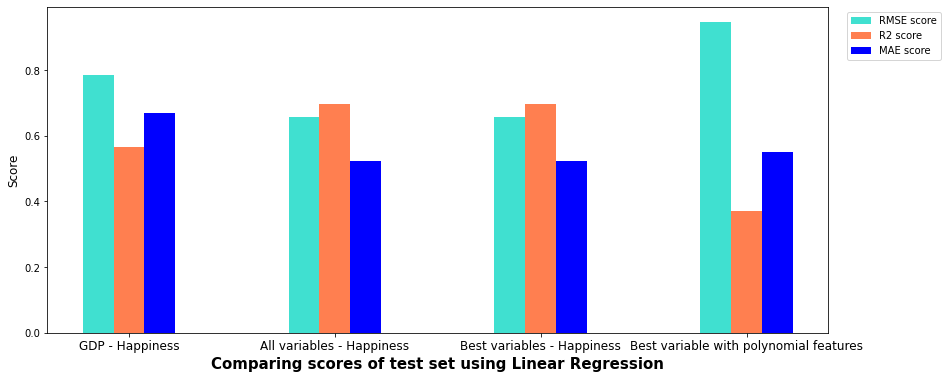

In [34]:
explore.plot_compare_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list,"Comparing scores of test set using Linear Regression",names)

**COMMENTS**: In the contrast of train set, the 16 features (excluding CO2_per_cap) with parameter tuning give us the worst prediction of all 4 predictions in the test set since it has lowest R2 score and highest error scores RMSE and MAE. The prediction using all 17 variables and using only 16 variables (with no tuning) give the similar result with 16 variables combination having a sightly better prediction, also has the best performance in predicing happiness scores with test set. However, since Using all 17 variables has a very minimal diference compare to using 16 features (excluding CO2_per_cap and no tuning), we should look at other regression models to confirm the selection of 16 or 17 features.

In [35]:
# using the value from using 16 variables without tunning
explore.store_scores_all_models(rmse_optimised,r2_optimised,y_test,y_test_pred)

## 4.3 Lasso Regression (Model 2)

In [36]:
# Create list of scores to compare each test of linear regression model
train_rmse_list = []
train_r2_list = []
train_mae_list = []
train_mape_list = []

test_rmse_list = []
test_r2_list = []
test_mae_list = []
test_mape_list = []

### 4.3.1 Use only GDP_per_cap to predict Happiness Score (Lasso)

In [37]:
lasso=Lasso(alpha = 0.01)

# model training
lasso.fit(X_gdp_train, y_gdp_train)

#predicting on training and testing test
y_train_pred = lasso.predict(X_gdp_train)
y_test_pred = lasso.predict(X_gdp_test)

explore.store_scores_all_models(rmse_gdp,r2_gdp,y_gdp_test, y_test_pred)
explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_gdp_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_gdp_test, y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_gdp_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_gdp_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.6819326395547503
R2-score:  0.6507711414631641
MAE:  0.5465584822565236
MAPE:  10.450498708631457

--------Metric scores on testing set--------
RMSE:  0.7878095713794033
R2-score:  0.5628985162598729
MAE:  0.6699817462576519
MAPE:  12.955696285186688



**COMMENT**: As seen from the model result, there are no significant gaps between the error metrics of training and testing set. However, comparing the results from training and testing set, we can see that the model is somewhat **overfitting**.

1. **RMSE**: The RMSE of training set is around 0.68, while for testing set it is approximately 0.78.
2. **R2 Score**: R2-score is higher in the training set (i.e. 0.65) compared to the testing set (i.e. 0.56). On the test result, R2-Score is only around 0.56, meaning only 56% of variations in happiness score is explained by the variations in GDP_per_cap.
4. **MAE**: The Mean Absolute Error for testing set is 0.66, much higher than that of training set (i.e. 0.54).
4. **MAPE**: The Mean Absolute Percent Error shows the percentage of errors compared to actual data. The MAPE for testing set is 12.95, which is large compared to MAPE value of 10.45 of the training set.

As a result, we would try to conduct the Lasso regression using all variables to see if the model improves.

In [38]:
print("The equation of using GDP is:")
print("y = ", lasso.coef_, "* x + ", lasso.intercept_) 

The equation of using GDP is:
y =  [2.17651463] * x +  3.3422008334727678


### 4.3.2 Use all variables to predict Happiness Score (Lasso)

In [39]:
# instantiating the model
lasso=Lasso(alpha=0.01)

# model training
lasso.fit(X_train, y_train)

#predicting on training and testing test
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.5208570230866412
R2-score:  0.7962656688343559
MAE:  0.4172121455814488
MAPE:  8.095895972634876

--------Metric scores on testing set--------
RMSE:  0.6606999299828787
R2-score:  0.6925685478490193
MAE:  0.5558320894436226
MAPE:  11.524508479484666



**COMMENT**: As seen from the model result, the model is still somehow overfitting based on the metric scores of training and testing set. However, scores have improved significantly.

1. **RMSE**: The RMSE for testing set it is approximately 0.66, which has been improved compared to the regression of using only 'Happiness_score' and 'GDP_per_cap'.
2. **R2 Score**: R2-score is higher now (i.e. 0.69) compared to the last model of only 0.56. This means that 69% of variations in happiness score is explained by the variations in GDP_per_cap.
3. **MAE**: The Mean Absolute Error for testing set is now 0.55, much less than the previous model of 0.66.
4. **MAPE**: The Mean Absolute Percent Error shows the percentage of errors compared to actual data. The MAPE for testing set is now 11.52, while for the previous model the MAPE is 12.95.

To conclude, the model has improved significantly taking into account of all variables. Therefore, we will use the original cleaned 'X' dataframe with multiple variables to do the RFE and cross validation.

### 4.3.3 Using RFE and Cross-validation to find number of important features (Lasso)

In [40]:
estimator = Lasso(alpha=0.01)

rmse_scores = []
r2_scores = []

for i in range(1, len(X_train.columns)+1):
    selector = RFE(estimator, n_features_to_select=i, step=1)
    score_rmse = cross_val_score(selector, X, y, scoring='neg_root_mean_squared_error', cv=5)
    score_r2 = cross_val_score(selector, X, y, scoring='r2', cv=5)
    
    print('%d features, have (r2, rmse) as: (%f, %f)' %(i,score_r2.mean(),-score_rmse.mean()))
    
    r2_scores.append(score_r2.mean())
    rmse_scores.append(-score_rmse.mean())

1 features, have (r2, rmse) as: (0.175903, 0.797513)
2 features, have (r2, rmse) as: (0.152262, 0.780246)
3 features, have (r2, rmse) as: (0.287723, 0.716228)
4 features, have (r2, rmse) as: (0.338255, 0.675872)
5 features, have (r2, rmse) as: (0.340181, 0.673761)
6 features, have (r2, rmse) as: (0.340164, 0.669432)
7 features, have (r2, rmse) as: (0.372777, 0.650533)
8 features, have (r2, rmse) as: (0.362910, 0.657860)
9 features, have (r2, rmse) as: (0.371831, 0.650198)
10 features, have (r2, rmse) as: (0.370683, 0.649883)
11 features, have (r2, rmse) as: (0.384388, 0.642968)
12 features, have (r2, rmse) as: (0.387334, 0.641567)
13 features, have (r2, rmse) as: (0.400833, 0.637049)
14 features, have (r2, rmse) as: (0.410793, 0.634568)
15 features, have (r2, rmse) as: (0.412186, 0.632984)
16 features, have (r2, rmse) as: (0.410507, 0.635057)
17 features, have (r2, rmse) as: (0.412630, 0.634310)


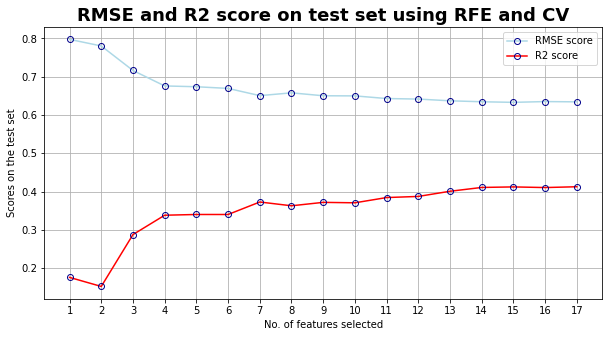

<Figure size 864x432 with 0 Axes>

In [41]:
explore.plot_compare_features(r2_scores, "R2 score" ,rmse_scores, "RMSE score",len(X_train.columns))

In [42]:
best_r2, best_rmse = explore.find_best_combination_index(r2_scores, rmse_scores)
print("R2 and RMAE has best result using number of feature respectedly:",best_r2, best_rmse)

R2 and RMAE has best result using number of feature respectedly: 17 15


**COMMENT**

R2 and RMAE has best result using number of feature respectedly: 17 15.

Our group has agreed on choosing the R2 score since R squared is a goodness-of-fit measure for regression model. It indicates the percentage of the variance in the dependent variable (i.e. Happiness score) that the independent variable (i.e. GDP_per_cap) explain collectively. R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale. 

Therefore, 17 features are important to produce the best R2 score. Thus, we will now do the parameter tuning using gridsearchCV to find the optimal result.

### 4.3.4 Parameter Tuning for Lasso Regression Model using GridSearchCV:
Because the number of features selected are still 17, use GridSearchCV as parameter tuning method

In [43]:
# set parameter range
parameters= {'alpha': [1e-15, 1e-10, 1e-8, 1e-5, 1e-3, 1e-2, 1, 5, 10, 20]}

# instantiating the model
lasso=Lasso()

# model training
lasso_search= GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_search.fit(X_train,y_train)

#predicting on training and testing test
y_train_pred = lasso_search.predict(X_train)
y_test_pred = lasso_search.predict(X_test)

explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.49819395133663247
R2-score:  0.8136093727711293
MAE:  0.3982827566682814
MAPE:  7.780081696999493

--------Metric scores on testing set--------
RMSE:  0.656149945779736
R2-score:  0.6967882901634599
MAE:  0.5257881772398891
MAPE:  11.172986754707566



**COMMENT**: GridSearchCV search explicitly through each parameter in the list to improve the result of predicting values. In particular, the alpha values will be changes to find which alpha is optimal. 

The metric scores are slighty improved now with R2 score increases from 0.6925 to 0.6967 now.

### 4.3.5 Comparing all train-test of Lasso regression
#### Test using train model

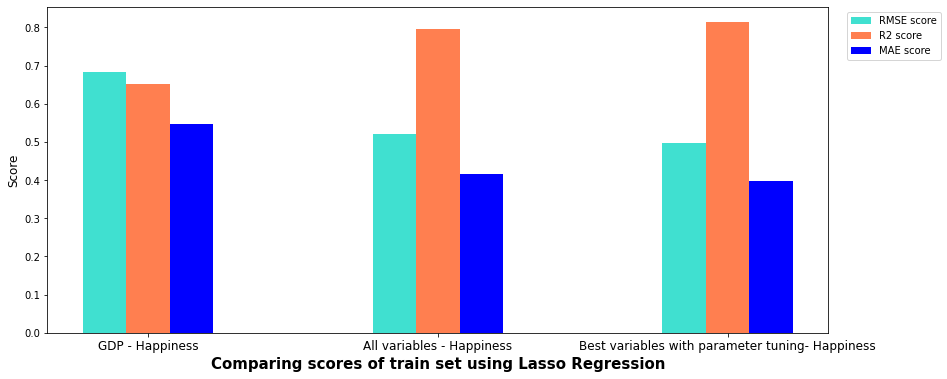

In [44]:
names = ['GDP - Happiness', 'All variables - Happiness', 'Best variables with parameter tuning- Happiness']
explore.plot_compare_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list,"Comparing scores of train set using Lasso Regression",names)

**COMMENT**: Group "All variables - Happiness" uses all variablles, while "Best variables with parameter tuning - Happiness" group uses the best 17 important features that the GridSearchCV provided. "GDP - Happiness" group with only using 'GDP_per_cap' provides the worst RMSE, MAE, and R2 scores.

Comparing the RMSE, R2, and MAE score. Scores are much better for the "Best variables with parameter tuning - Happiness" groups.
- RMSE score: lower in All/ Best variables.
- R2 score: higher in All/ Best variables.
- MAE score: lower in All/ Best variables.

#### Test using test model

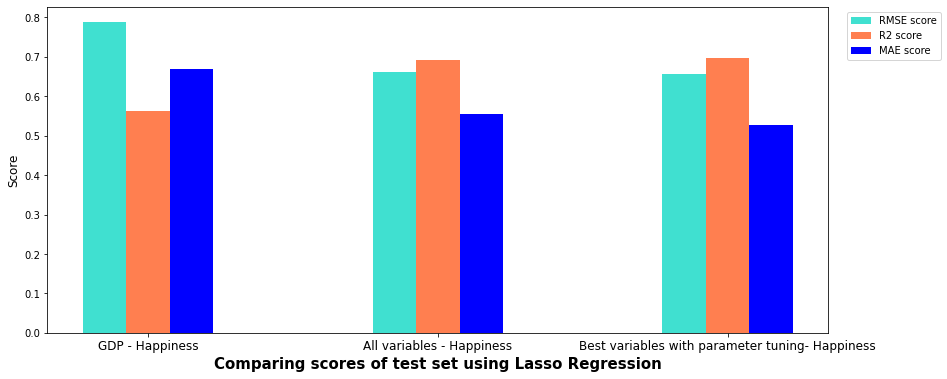

In [45]:
names = ['GDP - Happiness', 'All variables - Happiness', 'Best variables with parameter tuning- Happiness']
explore.plot_compare_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list,"Comparing scores of test set using Lasso Regression",names)

**COMMENT**: "Best variables with parameter tuning - Happiness" group uses the best 17 important features that the GridSearchCV provided, which provides the best RMSE, MAE, and R2 scores. "GDP - Happiness" group with only using 'GDP_per_cap' provides the worst scores.

Comparing the RMSE, R2, and MAE score. Scores are much better for the "Best variables with parameter tuning - Happiness" groups.

This also applies to the training set above.
- RMSE score: lower in All/ Best variables.
- R2 score: higher in All/ Best variables.
- MAE score: lower in All/ Best variablest.

In [46]:
explore.store_scores_all_models(rmse_optimised, r2_optimised, y_test,y_test_pred)

## 4.4. Random Forest Regression (Model 3)

In [47]:
# Create list of scores to compare each test of linear regression model
train_rmse_list = []
train_r2_list = []
train_mae_list = []
train_mape_list = []

test_rmse_list = []
test_r2_list = []
test_mae_list = []
test_mape_list = []

### 4.4.1. Use only GDP_per_cap to predict Happiness Score (RF)

In [48]:
rfr = RandomForestRegressor()

# model training
rfr.fit(X_gdp_train, y_gdp_train)

y_train_pred = rfr.predict(X_gdp_train)
y_test_pred = rfr.predict(X_gdp_test)

explore.store_scores_all_models(rmse_gdp,r2_gdp,y_gdp_test,y_test_pred)
explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_gdp_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_gdp_test, y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_gdp_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_gdp_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.2908192040404995
R2-score:  0.9364854344264857
MAE:  0.23041679484174465
MAPE:  4.470088987858232

--------Metric scores on testing set--------
RMSE:  0.8677080557624895
R2-score:  0.46974223889196864
MAE:  0.6575258772532141
MAPE:  12.63927921199118



**Comment:** As seen from the model result, there are big gaps between the error metrics of training and testing set. This means when the model is trained, the error results are marginal but when the trained model is tested on another unseen dataset, the errors increased considerably. 

1. **RMSE**: The RMSE of training set is only around 0.29, which is only around one third of the RMSE of testing set. RMSE for test set is huge, indicating large gaps between actual and predicted results.
2. **MAE**: The Mean Absolute Error in the test result shows relatively high value of approximately 0.66 while MAE in the training result is only one-third of that.
3. **MAPE**: The Mean Absolute Percent Error shows the percentage of errors compared to actual data. The MAPE for testing set is 12.6, which is noticeably large while MAE for training set shows a much smaller value. 
4. **R2 Score**: R2-score is much higher in the training data compared to that in the testing data. On the test result, R2-Score is only 0.47, meaning only 47% of variations in happiness score is explained by the variations in GDP_per_cap.  

These model results clearly indicate that the model is **overfitting**, and is trying to memorize each actual data point rather than predicting well the happiness score. Therefore, the Random Forest Regression model does not do a good job predicting happiness score based on money factor. 

### 4.4.2. Use multiple variables to predict Happiness Score (RF)

In [49]:
rfr = RandomForestRegressor()

# model training
rfr.fit(X_train, y_train)

#predicting on training and testing test
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  0.15637336797548057
R2-score:  0.9816366145904944
MAE:  0.11865232847121786
MAPE:  2.3523220406994607

--------Metric scores on testing set--------
RMSE:  0.48169817862085224
R2-score:  0.8365858033589334
MAE:  0.38306780110540484
MAPE:  7.740851571774256



**Comment:** As seen from the model result, even though gaps between error metrics of training and testing sets still exist, however, they are not significant as the Random Forest model using only money factor to predict happiness score. 

1. **RMSE**: The RMSE of test set is now 0.48, indicating below-average errors between actual and forecasted results. The differences between RMSE in the training and testing set still exist but are not significant.
2. **MAE**: The Mean Absolute Error in the test result shows relatively small errors between actual and predicted happiness score.
3. **MAPE**: The Mean Absolute Percent Error shows the percentage of errors compared to actual data. The MAPE here is not explicitly small with MAPE in the test set being more than 3 times that in the training set. 
4. **R2 Score**: the R2-Score is 0.84, implying 84% of the variations in happiness score is explained by the variations in 17 selected variables in the dataset. 

These model result clearly demonstrates that the model is **less overfitting** compared to the model with only GDP_per_cap feature. Therefore, the Random Forest Regression model has improved and does quite a good job predicting happiness score based on multiple factors listed above. 

In [50]:
rfr.feature_importances_

array([0.44302197, 0.02342507, 0.26022392, 0.04450155, 0.02183433,
       0.0551289 , 0.01678519, 0.00510397, 0.0193292 , 0.02077152,
       0.00905665, 0.00865984, 0.02346497, 0.01334153, 0.00726284,
       0.01434418, 0.01374437])

In [51]:
features_rank = pd.DataFrame({'Feature': list(X_train.columns),'Important score':rfr.feature_importances_})
features_rank = features_rank.sort_values(by='Important score',ascending=False,ignore_index=True)
features_rank

,Feature,Important score
0,GDP_per_cap,0.443022
1,life_expect,0.260224
2,pf_rol,0.055129
3,gov_trust,0.044502
4,ef_legal,0.023465
5,Family,0.023425
6,Generosity,0.021834
7,pf_expression,0.020772
8,pf_religion,0.019329
9,pf_ss,0.016785


**Comment:** As seen from the table above, according to Random Forest model, GDP_per_cap is the most important determinant of Happiness Score with the importance score of 0.44, implying money is a significant component of happiness. Besides, life_expect an pf_rol come as second and third important features with approximately 0.26 and 0.06 score respectively. Even though the rank is adjacent for the first 3 components, the importance score of money is roughly one and a half that of health factor and is nearly 7 times the score of elements relating to Rule of Law in a country. 

Meanwhile, pf_movement is the least important element with only around 0.005 importance score. This indicates that the personal freedom to travel is not considerably important when it comes to determining human happiness.

### 4.4.3. Use RFECV to find the most optimal features (RF)
RFECV is used to find the features that will result in the optimal results when Random Forest Regression is applied on the data

#### RFECV based on RMSE:

In [52]:
rfr = RandomForestRegressor()
rfecv_rmse = RFECV(estimator = rfr, step=1, cv=5, scoring='neg_root_mean_squared_error')
rfecv_rmse = rfecv_rmse.fit(X, y)
print('Optimal number of features based on RMSE: ', rfecv_rmse.n_features_)
print('Best features based on RMSE: ', X_test.columns[rfecv_rmse.support_])

Optimal number of features based on RMSE:  17
Best features based on RMSE:  Index(['GDP_per_cap', 'Family', 'life_expect', 'gov_trust', 'Generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'ef_government', 'ef_legal', 'ef_money', 'ef_trade',
       'ef_regulation', 'CO2_per_cap'],
      dtype='object')


**Comment:** Based on RMSE, 17 features are recommended to be used for the optimization of the model. The 17 features are listed as above. This means if 17 features listed above are used to predict happiness score, the RMSE will be minimized.

#### RFECV based on R2 Score:

In [53]:
rfr = RandomForestRegressor()
rfecv_r2 = RFECV(estimator = rfr, step=1, cv=5, scoring='r2')
rfecv_r2 = rfecv_r2.fit(X, y)
print('Optimal number of features based on R2 Score: ', rfecv_r2.n_features_)
print('Best features based on RMSE: ', X_test.columns[rfecv_r2.support_])

Optimal number of features based on R2 Score:  17
Best features based on RMSE:  Index(['GDP_per_cap', 'Family', 'life_expect', 'gov_trust', 'Generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'ef_government', 'ef_legal', 'ef_money', 'ef_trade',
       'ef_regulation', 'CO2_per_cap'],
      dtype='object')


**Comment:** Based on R2 Score, RFECV suggests that all 17 features be applied on the model to produce the most optimal result. This means if 17 features listed above are used to predict happiness score, the R2 Score will be maximized. 

#### Feature Optimization Plot based on RMSE and R2 Score:

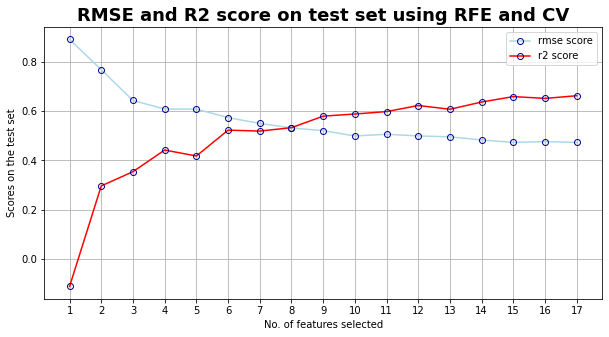

<Figure size 864x432 with 0 Axes>

In [54]:
explore.plot_compare_features(rfecv_r2.grid_scores_,"r2 score",-rfecv_rmse.grid_scores_,"rmse score",17)

**Comment:** From the graph above, R2 Score will be at its highest and RMSE will be at its lowest if all 17 features are used to predict Happiness Score if Random Forest model is used. Therefore, all 17 features are recommended to be used for the model

### 4.4.4. Parameter Tuning for Random Forest Model using RandomizedSearchCV:

In this model, parameter tuning is performed on Random Forest Regression Model using RandomizedSearchCV. This method generates random combinations of the hyperparameters to find the most optimal set of parameters for the model. 

In [55]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, X_train.shape[1]),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": randint(100, 500)}

rfr = RandomForestRegressor()
random_search = RandomizedSearchCV(rfr, param_distributions=param_dist, 
                                   n_iter=10, cv=5, iid=False, random_state=42)

random_search.fit(X_train, y_train)

rf = random_search.best_estimator_
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

explore.store_scores_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list, y_train,y_train_pred)
explore.store_scores_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list, y_test,y_test_pred)

# Calculating metrics scores
print("--------Metric scores on training set--------")
explore.print_model_score(y_train,y_train_pred)

print("--------Metric scores on testing set--------")
explore.print_model_score(y_test,y_test_pred)

--------Metric scores on training set--------
RMSE:  3.4210454518752876e-09
R2-score:  1.0
MAE:  4.178042651150813e-10
MAPE:  8.507443291656474e-09

--------Metric scores on testing set--------
RMSE:  0.4261270264020787
R2-score:  0.8721154929211048
MAE:  0.32136495729221765
MAPE:  6.62697331815658



**Comment:** As seen from the model result, the model is marginally underfitting, however, the gaps between different error metrics and R2 Score are not so significant. 

1. **RMSE**: The test result shows RMSE of 0.43, indicating below-average error estimation. 
2. **MAE**: The Mean Absolute Error in the test result shows relatively small errors between actual and predicted happiness score.
3. **MAPE**: The Mean Absolute Percent Error shows the percentage of errors compared to actual data. The MAPE here is not explicitly small, however, due to large dataset, this error result is acceptable
4. **R2 Score**: the test result shows relatively high R2-Score of 0.87, implying roughly 87% the variations in happiness score is explained by the variations in 17 selected variables in the dataset. 

Therefore, the model performs a better job compared to 2 Random Forest models above. There is no significant overfitting and the R2-score is higher while other error metrics are low.

### 4.4.5. Comparing Metric Scores of Train-test Results of RandomForest regression

#### Metric Scores of train set

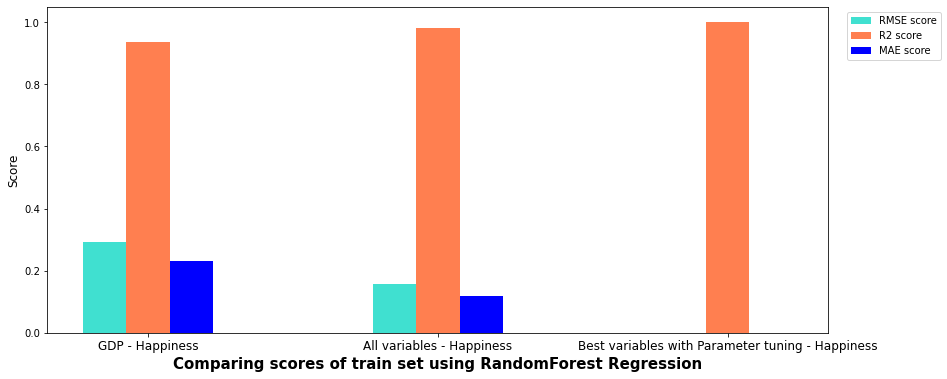

In [56]:
names = ['GDP - Happiness', 'All variables - Happiness', 'Best variables with Parameter tuning - Happiness']
explore.plot_compare_one_model(train_rmse_list, train_r2_list, train_mae_list, train_mape_list,"Comparing scores of train set using RandomForest Regression",names)

**Comments:** Random Forest Regression model performs better on train set when using important features (recommended by RFE) and parameter tuning with RandomizedSearchCV compared to the model using only money to predict happiness or the model which does not apply parameter tuning. R2 Score of the 3rd model is 1, which is higher than those of the 2 models left. RMSE & MAE scores of the 3rd model are close to 0, indicating the process of fitting this model works relatively smoothly. 

#### Metric Scores of test set

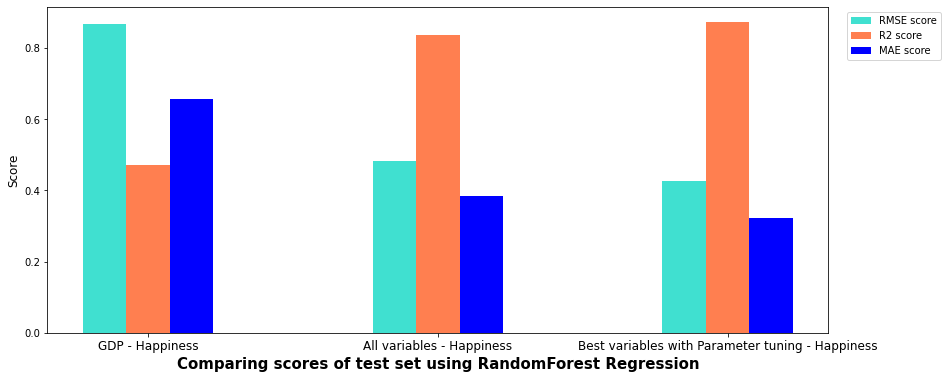

In [57]:
explore.plot_compare_one_model(test_rmse_list, test_r2_list, test_mae_list, test_mape_list,"Comparing scores of test set using RandomForest Regression",names)

**Comments:** On the test set, Random Forest Regression model performs better when using important features (recommended by RFE) and parameter tuning with RandomizedSearchCV compared to the model using only money to predict happiness or the model which does not apply parameter tuning. R2 Score of the 3rd model is 0.87, which indicates this model explains variations in the data well. That RMSE score is also higher than those of the 2 models left, and is almost half the R2 score of the 1st model (model using only GDP per cap to predict happiness score). RMSE & MAE scores of the 3rd model are the smaller compared to 2 other models' error metrics, indicating for unseen testing data, the 3rd model performs well the task of predicting happiness score

In [58]:
explore.store_scores_all_models(rmse_optimised,r2_optimised,y_test,y_test_pred)

## 5. Model Comparision and observation

## 5.1 Model Comparison based on R2 Score

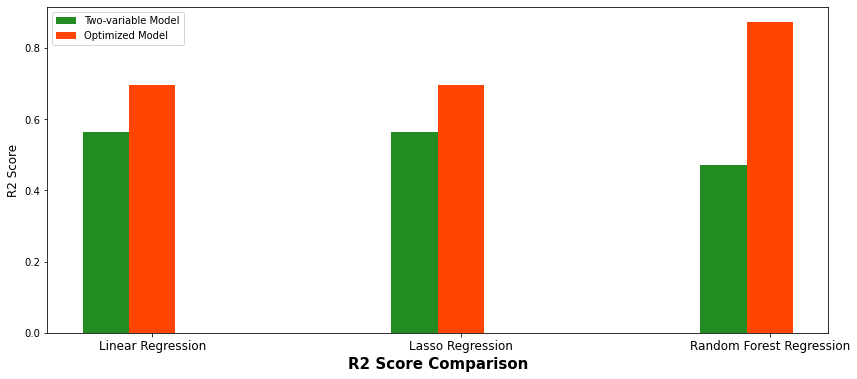

In [59]:
#R2 Score Comparison
from matplotlib.pyplot import figure

#set width of bar
barWidth = 0.15

# Set position of bar on X axis
bar1 = np.arange(len(r2_gdp))
bar2 = [x + barWidth for x in bar1]
bar3 = [x + barWidth for x in bar2]

figure(figsize=(14, 6))

# Make the plot
plt.bar(bar1, r2_gdp, color='forestgreen', width = barWidth, label='Two-variable Model')
plt.bar(bar2, r2_optimised, color='orangered', width = barWidth, label='Optimized Model')

# Add xticks on the middle of the group bars
plt.xlabel('R2 Score Comparison', fontweight='bold', fontsize=15)
plt.ylabel('R2 Score', fontsize=12)
plt.xticks([r + barWidth for r in range(len(r2_gdp))], ['Linear Regression', 'Lasso Regression', 'Random Forest Regression'], fontsize=12)


# Create legend & Show graphic
plt.legend()
plt.show()

**Comments:** Due the graph above, it can clearly be seen that:
1. **2-variable and optimized model:** For each type of regression, using multiple features that are recommended by RFE leads to higher R2 score results compared to using only money factor as the determinant:
    - R2 Score of Linear Regression Model is roughly 0.55 and 0.7 for the two-variable model (using only money as the predictor) and optimized model (using 16 selected features as predictor) respectively. 
    - R2 Score of Lasso Regression also increases by roughly 0.15 when using more features (17 selected features) rather than using only money
    - R2 Score of Random Forest Regression increases significantly from around 0.46 to 0.87 after applying 17 selected features rather than using only money factor as predictor. 
    
2. **Most Optimal Regression model:** Random Forest Regression model using 17 selected features as predictor produces the best R2 Score on the test set among all models. Higher R2 Score indicates higher percentage ofvariations in the data is explained by the model. Therefore, Random Forest Regression can be regarded as the most optimal model based on R2 Score, then comes Lasso Regression and finally Linear Regression

## 5.2 Model Comparison based on RMSE

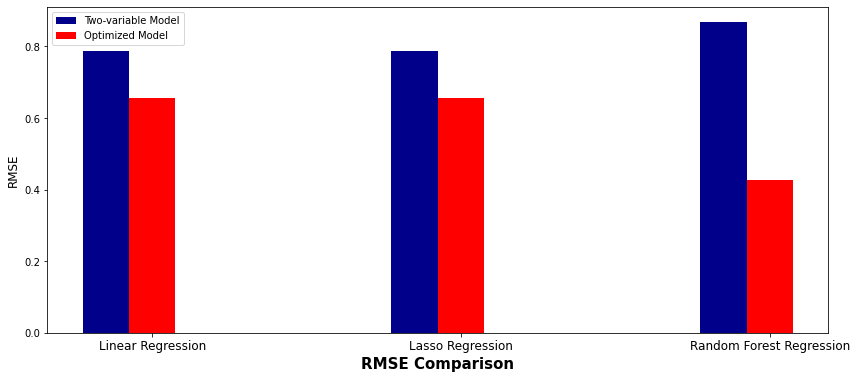

In [60]:
# RMSE Comparison

from matplotlib.pyplot import figure

#set width of bar
barWidth = 0.15

# Set position of bar on X axis
bar1 = np.arange(len(rmse_gdp))
bar2 = [x + barWidth for x in bar1]
bar3 = [x + barWidth for x in bar2]

figure(figsize=(14, 6))

# Make the plot
plt.bar(bar1, rmse_gdp, color='darkblue', width = barWidth, label='Two-variable Model')
plt.bar(bar2, rmse_optimised, color='red', width = barWidth, label='Optimized Model')

# Add xticks on the middle of the group bars
plt.xlabel('RMSE Comparison', fontweight='bold', fontsize=15)
plt.ylabel('RMSE', fontsize=12)
plt.xticks([r + barWidth for r in range(len(rmse_gdp))], ['Linear Regression', 'Lasso Regression', 'Random Forest Regression'], fontsize=12)


# Create legend & Show graphic
plt.legend()
plt.show()

**Comments:** Due the graph above, it can clearly be seen that:
1. **2-variable and optimized model:** For each type of regression, using multiple features that are recommended by RFE leads to lower RMSE compared to using only money factor as the determinant:
    - RMSE of Linear Regression Model is roughly 0.8 for the two-variable model (using only money as the predictor) and it decreases to just more than 0.6 for the optimized model (using 16 selected features as predictor).
    - RMSE of Lasso Regression also decreases by roughly 0.15 when using more features (17 selected features) rather than using only money
    - RMSE of Random Forest Regression decreases significantly from nearly 0.95 to approximately 0.4 after applying 17 selected features rather than using only money factor as predictor. 
    
2. **Most Optimal Regression model:** Random Forest Regression model using 17 selected features as predictor produces the lowest RMSE score on the test set among all models. Low RMSE shows small residual values between actual and predicted values. Therefore, Random Forest Regression can be regarded as the most optimal model based on RMSE, then comes Lasso Regression and finally Linear Regression

## 6. Conclusion

In order to answer the controversial question of **"Is money the only determinant of Happiness?"**, the project has worked on Data Cleaning, Data Exploration, Clustering, and applied 3 main types of Regression models on the dataset to evaluate if more features will make better contribution to the prediction of happiness score rather than using only money element. 

After critical analysis and discussion, it is concluded that: **Money is not the only determinant of happiness score**. Money is an essential contributor to happiness, however, people having only money are likely to be less happy compared to those who possess money and other elements such as good health condition, freedom of choice, family support, etc. Therefore, it is recommended that people pay a fair amount of attention to other lives factors rather than focusing solely on making money while deteriorating their health, freedom, family relationship and environment quality. 